## Importing libraries

In [1]:
# Importing the relevant libraries
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, Dense, Bidirectional, LSTM
from keras.models import Model
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.callbacks

import string
import re
import pandas as pd
import collections
import os
import time

import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using TensorFlow backend.


## Data Load

In [2]:
# We define a function to load the data
def load_data(path_to_dir, dataset):
    
    '''
    The loading procedure is different for the two datasets, therefore we add a parameter to the load 
    function that specifies the dataset to load
    '''
    
    # Regular Expression to remove punctuation
    Remove_punctuation = re.compile('[%s]' % re.escape(string.punctuation))
    
    if dataset == "imdb":
        
        train_pos = []
        train_neg = []
        test_pos = []
        test_neg = []

        for filename in os.listdir(path_to_dir+"/train/pos/"):
            train_pos.append(open(path_to_dir+"/train/pos/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/train/neg/"):
            train_neg.append(open(path_to_dir+"/train/neg/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/test/pos/"):
            test_pos.append(open(path_to_dir+"/test/pos/"+filename,'r',encoding='utf-8').read())

        for filename in os.listdir(path_to_dir+"/test/neg/"):
            test_neg.append(open(path_to_dir+"/test/neg/"+filename,'r',encoding='utf-8').read())
        
        train_pos = [Remove_punctuation.sub('',i).lower().split() for i in train_pos]
        train_neg = [Remove_punctuation.sub('',i).lower().split() for i in train_neg]
        test_pos = [Remove_punctuation.sub('',i).lower().split() for i in test_pos]
        test_neg = [Remove_punctuation.sub('',i).lower().split() for i in test_neg]
        
        X_train = train_pos + train_neg
        X_test = test_pos + test_neg
        
        Y_train = [1]*len(train_pos) + [0]*len(train_neg)
        Y_test = [1]*len(test_pos) + [0]*len(test_neg)        
        
        return X_train, Y_train, X_test, Y_test
        
    if dataset == "yelp":
        
        Train_data = pd.read_csv(path_to_dir + "Yelp_train_data.csv")
        Train_data = Train_data[Train_data['stars']!=3]
        
        X_train = Train_data['text']
        X_train = list(X_train)
        
        Y_train = Train_data['stars']
        Y_train = list(Y_train)
        Y_train = [0 if i <= 3 else 1 for i in Y_train]
        
        Test_data =  pd.read_csv(path_to_dir + "Yelp_test_data.csv")
        Test_data = Test_data[Test_data['stars']!=3]
        
        X_test = Test_data['text']
        X_test = list(X_test)
        
        Y_test = Test_data['stars']
        Y_test = list(Y_test)
        Y_test = [0 if i <=3 else 1 for i in Y_test]
        
        X_train = [Remove_punctuation.sub('',i).lower().split() for i in X_train]
        X_test = [Remove_punctuation.sub('',i).lower().split() for i in X_test]
               
        return X_train, Y_train, X_test, Y_test       


In [4]:
X_train, Y_train, X_test, Y_test = load_data('../../../Data/IMDB Stanford/', "imdb")

## Data Pre Processing

In [5]:
def stopwords(corpus, proportion = 0.5):
    
    ''' This function is built to identify stopwords specific to the dataset in question
    '''
    unique_sent_words = [list(set(sentence)) for sentence in corpus]
    flattened_word_list = [item for sublist in unique_sent_words for item in sublist]
    doc_count = dict(collections.Counter(flattened_word_list))
    stopwords = [key for key, value in doc_count.items() if value >= proportion * len(corpus)]
    
    return set(stopwords)

In [6]:
stopwords_list = stopwords(X_train, proportion=0.4)

In [7]:
# Removing stopwords from the training data

X_train = [[word for word in data if word not in stopwords_list] for data in X_train]

In [8]:
# Setting up parameters for the word embeddings

Max_Words = 20000 #Max words in the vocabulary
Max_Sequence_length = 1000 #Max number of words in a review
Embedding_dimension = 100 #Using 100 dimensional Glove data


In [9]:
# Converting the words into tokens

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
data_sequence_train = tokenizer.texts_to_sequences(X_train)
data_sequence_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

In [10]:
# Padding the Train and Test data

Train_data = pad_sequences(data_sequence_train, maxlen = Max_Sequence_length)
Test_data = pad_sequences(data_sequence_test, maxlen = Max_Sequence_length)

# Creating the labels
Train_labels = np.array(Y_train)
Test_labels = np.array(Y_test)

In [11]:
# Splitting the training data into train and validation sets

Validation_set_frac = 0.2

Indices = np.arange(Train_data.shape[0])
np.random.shuffle(Indices)

X_train = Train_data[Indices]
Y_train = Train_labels[Indices]

Val_sample_size = int(Validation_set_frac*Train_data.shape[0]) # We use 20% of data for validation

X_train = X_train[:-Val_sample_size]
Y_train = Y_train[:-Val_sample_size]

X_val = X_train[-Val_sample_size:]
Y_val = Y_train[-Val_sample_size:]

print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)


(20000, 1000) (20000,) (5000, 1000) (5000,)


## Feature Engineering

In [12]:
# Loading the glove vector data

embedding_dict = {}
glove_file = open('../../../Data/Glove Data/glove.6B.100d.txt',encoding='utf8')
for line in glove_file:
    values = line.split()
    word = values[0]
    word_vec = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = word_vec
glove_file.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embedding_dict))

Total 400000 word vectors in Glove 6B 100d.


In [13]:
# Creating an embedding layer with weights as glove vector embeddings

weights = np.random.random((len(word_index) + 1, 100))

for word, i in word_index.items():
    word_vec = embedding_dict.get(word)
    if word_vec is not None:
        # words not found in embedding index will be all-zeros.
        weights[i] = word_vec

Embedding_input = Embedding(len(word_index) + 1, 100,weights=[weights], input_length=Max_Sequence_length,trainable=False)

## RNN Model

In [14]:
# RNN Model

'''The RNN Model is implemented using the functional model APIs from Keras'''

Input_layer = Input(shape=(Max_Sequence_length,))
Embedding_layer = Embedding_input(Input_layer)
LSTM_layer = Bidirectional(LSTM(100))(Embedding_layer)
Output_layer = Dense(1, activation='sigmoid')(LSTM_layer)

RNN_model = Model(inputs=Input_layer, outputs=Output_layer)

RNN_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# Creating callback to measure time per epoch during training
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Time_callback = TimeHistory()

# Creating a callback for Earlystopping
Early_Stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [16]:
RNN_Training = RNN_model.fit(X_train,Y_train, validation_data = (X_val, Y_val), epochs = 20, batch_size = 500, callbacks = [Time_callback, Early_Stopping])


Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 131s 7ms/step - loss: 0.6119 - acc: 0.6670 - val_loss: 0.5563 - val_acc: 0.7260
Epoch 2/20
20000/20000 [==============================] - 132s 7ms/step - loss: 0.5096 - acc: 0.7574 - val_loss: 0.5644 - val_acc: 0.7118
Epoch 3/20
20000/20000 [==============================] - 133s 7ms/step - loss: 0.5015 - acc: 0.7624 - val_loss: 0.4694 - val_acc: 0.7854
Epoch 4/20
20000/20000 [==============================] - 133s 7ms/step - loss: 0.4584 - acc: 0.7903 - val_loss: 0.4390 - val_acc: 0.8002
Epoch 5/20
20000/20000 [==============================] - 129s 6ms/step - loss: 0.4237 - acc: 0.8092 - val_loss: 0.4103 - val_acc: 0.8144
Epoch 6/20
20000/20000 [==============================] - 131s 7ms/step - loss: 0.4192 - acc: 0.8106 - val_loss: 0.3936 - val_acc: 0.8190
Epoch 7/20
20000/20000 [==============================] - 131s 7ms/step - l

In [17]:
# Saving the model to disk
RNN_model.save('RNN_model.h5')

# Saving the model configuration file to disk
RNN_model_json = RNN_model.to_json()
with open("RNN_model.json", "w") as json_file:
    json_file.write(RNN_model_json)

## Model Performance Metrics

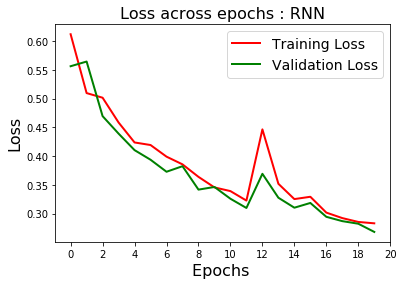

In [18]:
# Plotting the training/validation loss across epochs

figure1 = plt.figure()
plt.plot(RNN_Training.history['loss'],'r',linewidth=2.0)
plt.plot(RNN_Training.history['val_loss'],'g',linewidth=2.0)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(list(range(0,len(Time_callback.times)+1,2)))
#plt.ylim(0,0.6)
#plt.xlim(0,4)
plt.title('Loss across epochs : RNN',fontsize=16)
figure1.savefig('./Performance Graphs/RNN_model_Loss_Graph.png')
plt.show()

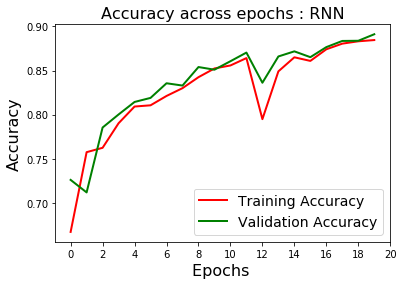

In [19]:
# Plotting the training/validation accuracy across epochs

figure2 = plt.figure()
plt.plot(RNN_Training.history['acc'],'r',linewidth=2.0)
plt.plot(RNN_Training.history['val_acc'],'g',linewidth=2.0)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(list(range(0,len(Time_callback.times)+1,2)))
#plt.ylim(0.4,1.0)
#plt.xlim(0,4)
plt.title('Accuracy across epochs : RNN',fontsize=16)
figure2.savefig('./Performance Graphs/RNN_model_Accuracy_Graph.png')
plt.show()

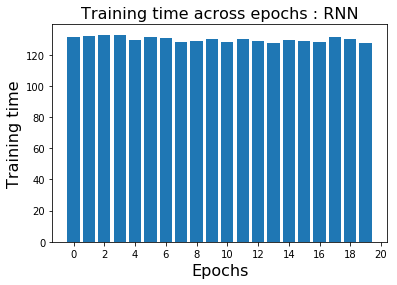

In [20]:
# Plotting the time taken per epoch

figure3 = plt.figure()
epochs = list(range(1,len(Time_callback.times)+1))
time_per_epoch = Time_callback.times
index = np.arange(len(epochs))

plt.bar(index, time_per_epoch)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training time', fontsize=16)
plt.xticks(list(range(0,len(Time_callback.times)+1,2)))
plt.title('Training time across epochs : RNN', fontsize = 16)
figure3.savefig('./Performance Graphs/RNN_model_Training_Time_Graph.png')
plt.show()
